In [1]:
import sys

sys.path.insert(0, '..')

## Setup the model area

In [2]:
from morpheus.project.types.discretization import SpatialDiscretization
from morpheus.project.types.discretization.spatial import Rotation, Grid, Crs
from morpheus.project.types.geometry import Polygon, LineString

polygon = Polygon(
  type='Polygon',
  coordinates=[[
    (13.92, 50.964),
    (13.92, 50.966),
    (13.925, 50.966),
    (13.925, 50.964),
    (13.92, 50.964)
  ]]
)

rotation = Rotation(0)

grid = Grid.cartesian_from_polygon(polygon=polygon, n_col=100, n_row=50, rotation=rotation)
spatial_discretization = SpatialDiscretization.from_geometry_with_grid(
  geometry=polygon,
  grid=grid,
  crs=Crs.from_str('EPSG:4326')
)

## Setup Time Discretization

In [3]:
from morpheus.project.types.discretization.time.TimeUnit import TimeUnit
from morpheus.project.types.discretization.time.Stressperiods import StartDateTime, StressPeriodCollection, \
  StressPeriod, NumberOfTimeSteps, TimeStepMultiplier, IsSteadyState
from morpheus.project.types.discretization.time import TimeDiscretization
from datetime import datetime

time_discretization = TimeDiscretization(
  start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
  end_date_time=StartDateTime.from_datetime(datetime(2020, 12, 31)),
  stress_periods=StressPeriodCollection([
    StressPeriod(
      start_date_time=StartDateTime.from_datetime(datetime(2020, 1, 1)),
      number_of_time_steps=NumberOfTimeSteps(1),
      time_step_multiplier=TimeStepMultiplier(1),
      steady_state=IsSteadyState.yes()
    ),
  ]),
  time_unit=TimeUnit.days()
)

# Setup Model

In [4]:
from morpheus.project.types.Model import Model

model = Model.new()
model = model.with_updated_time_discretization(time_discretization)
model = model.with_updated_spatial_discretization(spatial_discretization=spatial_discretization)

In [5]:
import folium

m = folium.Map(tiles="cartodbpositron", crs="EPSG3857", zoom_start=12, location=[50.965, 13.922])
m.add_child(folium.GeoJson(polygon.as_geojson()))

m.fit_bounds(m.get_bounds())
m

# Setup general head boundaries

In [6]:
from morpheus.project.types.boundaries.GeneralHeadObservation import ObservationId, GeneralHeadRawDataItem, \
  GeneralHeadObservation, Stage, Conductance
from morpheus.project.types.geometry import Point
from morpheus.project.types.boundaries.Boundary import BoundaryName, BoundaryCollection
from morpheus.project.types.soil_model import LayerId
from morpheus.project.types.boundaries.Boundary import GeneralHeadBoundary

layers_list = [LayerId.new()]

general_head_east = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_east'),
  geometry=LineString([
    (13.92499, 50.966),
    (13.92499, 50.964),
  ]),
  grid=grid,
  affected_layers=[model.soil_model.layers[0].id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92499, 50.966)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(100),
        ),
      ]
    ),
  ]
)

general_head_west = GeneralHeadBoundary.from_geometry(
  name=BoundaryName('general_head_west'),
  geometry=LineString([
    (13.92004, 50.96401),
    (13.92004, 50.96599),
  ]),
  grid=grid,
  affected_layers=[model.soil_model.layers[0].id],
  observations=[
    GeneralHeadObservation(
      observation_id=ObservationId.new(),
      geometry=Point((13.92004, 50.96599)),
      raw_data=[
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(300),
        ),
        GeneralHeadRawDataItem(
          date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
          stage=Stage.from_float(100),
          conductance=Conductance.from_float(300),
        ),
      ]
    ),
  ]
)

boundary_collection = BoundaryCollection.new()
boundary_collection.add_boundary(general_head_west)
boundary_collection.add_boundary(general_head_east)

model = model.with_updated_boundaries(boundaries=boundary_collection)

m.add_child(folium.GeoJson(general_head_east.as_geojson()))
m.add_child(folium.GeoJson(general_head_east.affected_cells.as_geojson(grid).as_geojson()))
for observation in general_head_east.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))

m.add_child(folium.GeoJson(general_head_west.as_geojson()))
m.add_child(folium.GeoJson(general_head_west.affected_cells.as_geojson(grid).as_geojson()))
for observation in general_head_west.observations:
  m.add_child(folium.GeoJson(observation.as_geojson()))
m.fit_bounds(m.get_bounds())
m

# Setup Evapotranspiration Boundary

In [7]:
from morpheus.project.types.boundaries.Boundary import EvapotranspirationBoundary
from morpheus.project.types.boundaries.EvapotranspirationObservation import EvapotranspirationRawDataItem, \
  ExtinctionDepth, SurfaceElevation, Evapotranspiration

evapotranspiration_area = Polygon(
  type='Polygon',
  coordinates=[[
    (
      13.92181326103696,
      50.96574333352123
    ),
    (
      13.92181326103696,
      50.96440649737727
    ),
    (
      13.923994608237564,
      50.96440649737727
    ),
    (
      13.923994608237564,
      50.96574333352123
    ),
    (
      13.92181326103696,
      50.96574333352123
    )
  ]]

)

evapotranspiration = EvapotranspirationBoundary.from_geometry(
  name=BoundaryName('evapotranspiration'),
  geometry=evapotranspiration_area,
  grid=grid,
  affected_layers=[model.soil_model.layers[0].id],
  raw_data=[
    EvapotranspirationRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2019, 1, 1)),
      evapotranspiration=Evapotranspiration.from_float(0.001),
      extinction_depth=ExtinctionDepth.from_float(0.1),
      surface_elevation=SurfaceElevation.from_float(100),
    ),
    EvapotranspirationRawDataItem(
      date_time=StartDateTime.from_datetime(datetime(2021, 12, 31)),
      evapotranspiration=Evapotranspiration.from_float(0.001),
      extinction_depth=ExtinctionDepth.from_float(0.1),
      surface_elevation=SurfaceElevation.from_float(100),
    ),
  ]
)

boundary_collection.add_boundary(evapotranspiration)

m.add_child(folium.GeoJson(evapotranspiration.as_geojson()))
m.add_child(folium.GeoJson(evapotranspiration.affected_cells.as_geojson(grid).as_geojson()))
m.fit_bounds(m.get_bounds())
m

In [8]:
from morpheus.project.infrastructure.calculation.engines.modflow_2005.packages.EvtPackageMapper import \
  calculate_evt_boundary_stress_period_data

result = calculate_evt_boundary_stress_period_data(
  spatial_discretization=spatial_discretization,
  time_discretization=time_discretization,
  soil_model=model.soil_model,
  evt_boundary=evapotranspiration,
)
result.to_dict(2)[0]

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0

## Calculate

In [9]:
from morpheus.project.types.calculation.CalculationProfile import CalculationProfile, CalculationEngineType
from morpheus.project.types.calculation.Calculation import Calculation

calculation_profile = CalculationProfile.new(CalculationEngineType.MF2005)
calculation = Calculation.new(model=model, calculation_profile=calculation_profile)

In [10]:
calculation = Calculation.from_dict(calculation.to_dict())
calculation.calculation_id

CalculationId(value='672091a6-022b-4000-9d04-fe41148b0c04')

In [11]:
from morpheus.project.infrastructure.calculation.services.CalculationService import CalculationService

calculation_service = CalculationService.from_calculation(calculation)
calculation_service.calculate()

FloPy is using the following executable to run the model: ../../../../../../../src/backend/.venv/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: 27e00196-362e-4c7a-8abd-b83ee7d72277.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/03/22 10:05:18

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/03/22 10:05:18
 Elapsed run time:  0.022 Seconds

  Normal termination of simulation


In [12]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['27e00196-362e-4c7a-8abd-b83ee7d72277.ghb', '27e00196-362e-4c7a-8abd-b83ee7d72277.list', '27e00196-362e-4c7a-8abd-b83ee7d72277.pcg', '27e00196-362e-4c7a-8abd-b83ee7d72277.dis', '27e00196-362e-4c7a-8abd-b83ee7d72277.hds', '27e00196-362e-4c7a-8abd-b83ee7d72277.evt', '27e00196-362e-4c7a-8abd-b83ee7d72277.oc', '27e00196-362e-4c7a-8abd-b83ee7d72277.nam', '27e00196-362e-4c7a-8abd-b83ee7d72277.lpf', '27e00196-362e-4c7a-8abd-b83ee7d72277.bas'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

In [13]:
head = calculation_service.read_head(0, 0)

In [14]:
import simplejson as json

json = json.dumps(head, ignore_nan=True)
json

'[[100.0, 99.99700164794922, 99.99500274658203, 99.99199676513672, 99.98999786376953, 99.98699951171875, 99.98400115966797, 99.98200225830078, 99.97899627685547, 99.97699737548828, 99.9739990234375, 99.97200012207031, 99.96900177001953, 99.96600341796875, 99.96399688720703, 99.96099853515625, 99.95899963378906, 99.95600128173828, 99.9540023803711, 99.95099639892578, 99.9489974975586, 99.94599914550781, 99.94400024414062, 99.94100189208984, 99.93900299072266, 99.93599700927734, 99.93399810791016, 99.93099975585938, 99.92900085449219, 99.927001953125, 99.92400360107422, 99.9219970703125, 99.91999816894531, 99.91799926757812, 99.91600036621094, 99.91400146484375, 99.91200256347656, 99.91100311279297, 99.90899658203125, 99.90799713134766, 99.90699768066406, 99.90599822998047, 99.90499877929688, 99.90399932861328, 99.90399932861328, 99.90299987792969, 99.90299987792969, 99.9020004272461, 99.9020004272461, 99.9020004272461, 99.9020004272461, 99.9010009765625, 99.9010009765625, 99.90100097656

In [15]:
calculation_service.read_drawdown(0, 0)

[]

In [16]:
calculation_service.read_budget(0, False)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'ET_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 161.1991,
 'TOTAL_IN': 161.1991,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'ET_OUT': -161.2403,
 'HEAD_DEP_BOUNDS_OUT': -0.0,
 'TOTAL_OUT': -161.2403,
 'IN-OUT': -0.041214,
 'PERCENT_DISCREPANCY': -0.03,
 'tslen': 365.0}

In [17]:
calculation_service.read_budget(0, True)

{'STORAGE_IN': 0.0,
 'CONSTANT_HEAD_IN': 0.0,
 'ET_IN': 0.0,
 'HEAD_DEP_BOUNDS_IN': 0.4416,
 'TOTAL_IN': 0.4416,
 'STORAGE_OUT': -0.0,
 'CONSTANT_HEAD_OUT': -0.0,
 'ET_OUT': -0.4418,
 'HEAD_DEP_BOUNDS_OUT': -0.0,
 'TOTAL_OUT': -0.4418,
 'IN-OUT': -0.00011295,
 'PERCENT_DISCREPANCY': -0.03,
 'tslen': 365.0}

In [18]:
calculation_service.get_result()

CalculationResult(type=<CalculationResultType.SUCCESS: 'success'>, message='Calculation finished successfully', files=['27e00196-362e-4c7a-8abd-b83ee7d72277.ghb', '27e00196-362e-4c7a-8abd-b83ee7d72277.list', '27e00196-362e-4c7a-8abd-b83ee7d72277.pcg', '27e00196-362e-4c7a-8abd-b83ee7d72277.dis', '27e00196-362e-4c7a-8abd-b83ee7d72277.hds', '27e00196-362e-4c7a-8abd-b83ee7d72277.evt', '27e00196-362e-4c7a-8abd-b83ee7d72277.oc', '27e00196-362e-4c7a-8abd-b83ee7d72277.nam', '27e00196-362e-4c7a-8abd-b83ee7d72277.lpf', '27e00196-362e-4c7a-8abd-b83ee7d72277.bas'], head_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=1, number_of_observations=0), drawdown_results=None, budget_results=AvailableResults(times=[365.0], kstpkper=[(0, 0)], number_of_layers=0, number_of_observations=0), concentration_results=None)

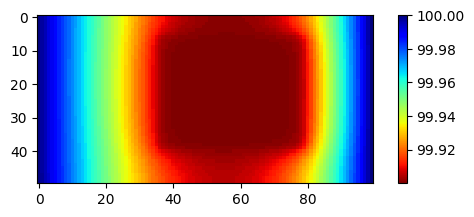

In [19]:
import matplotlib.pyplot as plt

heads = calculation_service.read_head(0, 0)
plt.subplot(2, 1, 1)
plt.imshow(heads, cmap='jet_r')
plt.colorbar()
plt.show()